In [26]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import keras
from keras.layers import Input, Dense, Flatten, Reshape, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [29]:
img_dim = x_train.shape[1] * x_train.shape[2]
img_shape = (x_train.shape[1], x_train.shape[2])
print x_train.shape, x_test.shape

(60000, 28, 28) (10000, 28, 28)


In [0]:
x_train = x_train.astype('float32') / 127.5 - 1
x_test = x_test.astype('float32') / 127.5 - 1

In [0]:
latent_dim = 100

In [32]:
noise = Input(shape=(latent_dim,))
x = Dense(256)(noise)
x = LeakyReLU(alpha = 0.2)(x)
x = BatchNormalization(momentum=0.8)(x)
x = Dense(512)(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(momentum=0.8)(x)
x = Dense(1024)(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(momentum=0.8)(x)
x = Dense(img_dim, activation = 'tanh')(x)
g_imgs = Reshape(img_shape)(x)
g_model = Model(noise, g_imgs)
g_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
__________

In [33]:

inputs = Input(shape=img_shape)
x = Flatten()(inputs)
x = Dense(512)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dense(256)(x)
x = LeakyReLU(alpha=0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)
d_model = Model(inputs, outputs)
d_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total para

In [0]:
d_model.compile(loss = 'binary_crossentropy',
            optimizer = Adam(0.0002, 0.5),
            metrics = ['accuracy'])

In [35]:
inputs = Input(shape=(latent_dim,))
d_model.trainable = False
imgs = g_model(inputs)
outputs = d_model(imgs)
adverserial_model = Model(inputs, outputs)
adverserial_model.compile(loss= 'binary_crossentropy',
            optimizer = Adam(0.0002, 0.5),
            metrics = ['accuracy'])
adverserial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_4 (Model)              (None, 28, 28)            1493520   
_________________________________________________________________
model_5 (Model)              (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


In [0]:
adverserial_model.layers[-1].trainable = False


In [0]:
def get_batch(batch, gen_imgs):
    indexes = np.random.randint(0, x_train.shape[0], batch)
    x_batch = np.vstack((x_train[indexes],gen_imgs))
    return x_batch

In [38]:
batch_size = 32
y_batch = np.vstack((np.ones((batch_size, 1)),np.zeros((batch_size, 1))))
for ep in range(30000):
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_imgs = g_model.predict(noise)
    x_batch =  get_batch(batch_size, generated_imgs)
    d_loss = d_model.train_on_batch(x_batch, y_batch)
    g_loss = adverserial_model.train_on_batch(noise, y_batch[:batch_size])
    if ep%1000==0:
        print "epoch:",ep," ",d_loss[0], g_loss[0]

epoch: 0   0.68875355 0.69415927
epoch: 1000   0.63635457 0.9059834
epoch: 2000   0.6043301 0.67585415
epoch: 3000   0.6043514 0.8414571
epoch: 4000   0.6644433 0.84592015
epoch: 5000   0.70902336 0.6389384
epoch: 6000   0.60619545 1.0727189
epoch: 7000   0.6162267 0.89665574
epoch: 8000   0.7271905 0.95717895
epoch: 9000   0.6541798 0.93188655
epoch: 10000   0.6473229 0.89111406
epoch: 11000   0.68158793 0.7631705
epoch: 12000   0.59111726 0.7801891
epoch: 13000   0.61010206 0.8399805
epoch: 14000   0.6506281 1.0208528
epoch: 15000   0.70844615 0.8898943
epoch: 16000   0.6137046 0.8125288
epoch: 17000   0.62033546 1.0902128
epoch: 18000   0.65594745 0.9472653
epoch: 19000   0.65130866 1.158675
epoch: 20000   0.6241965 1.044105
epoch: 21000   0.65382135 0.97030205
epoch: 22000   0.5725448 1.2051294
epoch: 23000   0.59412193 1.0180151
epoch: 24000   0.56354046 0.8520777
epoch: 25000   0.6482684 0.709743
epoch: 26000   0.5905544 1.1496415
epoch: 27000   0.6654391 0.8311376
epoch: 28000  

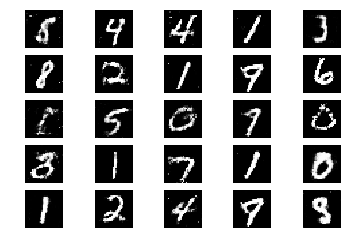

In [44]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, 100))
gen_imgs = g_model.predict(noise)

        # Rescale images 0 - 1

gen_imgs = 0.5 * gen_imgs + 0.5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
       